### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

### Ground truth

In [4]:
protons = [12, 8]

In [5]:
molar_proportions = [0.3702, 0.6298]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.468568053328833, 0.5314319466711671]

### Loading the data

In [7]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [8]:
mix = np.loadtxt(os.getcwd()+'/1H_manisaldehyde_benzylbenzoate_DMSO.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [9]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [10]:
spectra = []
for comp_ints in components_ints:
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [11]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


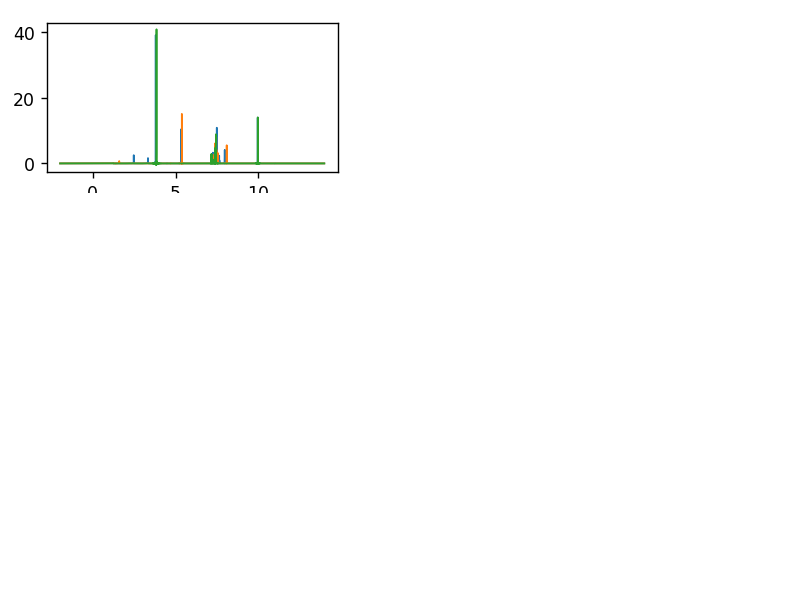

In [12]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Alignment

In [13]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [14]:
# shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
# mix = shift_one_spectrum(mix, -0.1)

### Preprocessing

In [15]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        return (min_of_min - epsilon)*(-1)
    else:
        return(0)

In [16]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [17]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [18]:
spectra_and_mixture = spectra + [mix]

In [19]:
shift_coef = shift(spectra_and_mixture)

In [20]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [21]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [22]:
cma = common_mass_axis(spectra_and_mixture)

In [23]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [24]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [25]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [26]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

### Removing unnecessary data points

In [27]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [28]:
#3.5, 12
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.5-shift_coef, 12-shift_coef)

In [29]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [30]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [31]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [32]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [33]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [34]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [35]:
official_names

['Benzyl_benzoate', 'm Anisaldehyde']

In [36]:
labels = official_names + ['Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


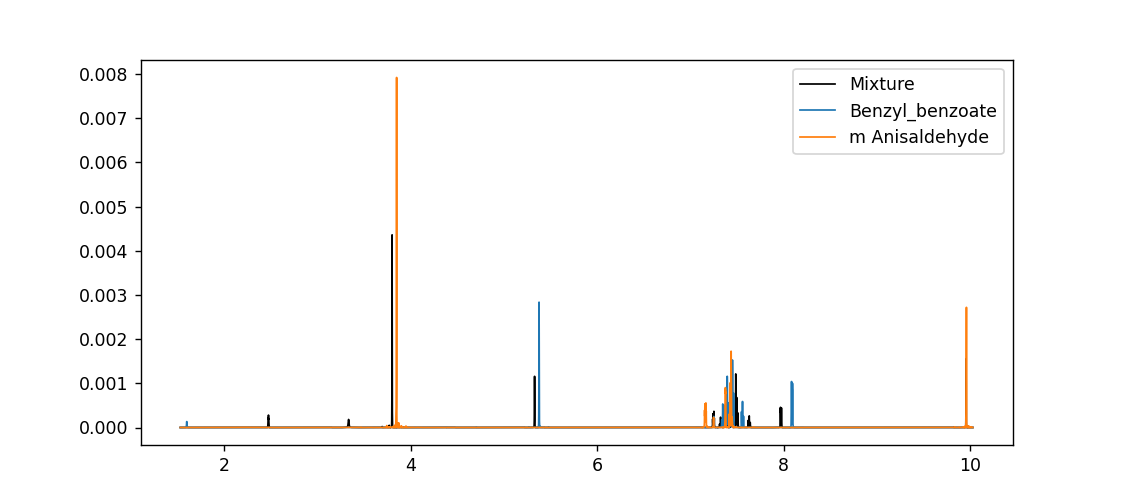

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
ax.legend()

### Finding best kappa

In [38]:
import time
import pandas as pd
import pulp

In [39]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [40]:
# list_of_estimation_results = []
# list_of_noise_prop = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     fixed_kappa_noise_prop = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         fixed_kappa_noise_prop.append(estimation['proportion_of_noise_in_theoretical'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#         print(estimation['proportion_of_noise_i+n_t+heoretical'])
#     list_of_estimation_results.append(fixed_kappa)
#     list_of_noise_prop.append(fixed_kappa_noise_prop)

In [41]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

#### Molar proportions

In [42]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [43]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [44]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [45]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [46]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [47]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [48]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [49]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [50]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [51]:
all_components_results_both.min().min()

0.004972192615631976

In [52]:
all_components_results_both[0.02][0.13]

0.004972192615631976

### Saving preprocessed spectra

In [55]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')

In [ ]:
#this is different from the file in the repo (only ppm column, the second one is identical). TO DO: check why